# This is going to be awesome

### Imports

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [111]:
colors = ['#6A89A7', '#BDDDFC', '#88BDF2', '#384959']

In [87]:
pre = pd.read_csv('data/pre.csv', quotechar='\t')
during = pd.read_csv('data/during.csv', quotechar='\t')
post = pd.read_csv('data/post.csv', quotechar='\t')
pre.columns

Index(['"Timestamp', '""Participant ID (top-right corner of the screen)""',
       '""How old are you?""', '""Gender?""',
       '""What describes you the best?""',
       '""How comfortable are you in expressing emotions?""',
       '""Have you ever played with the drummer bot dB before?""',
       '""How much prior experience do you have with interactive musical interfaces (e.g. sensor systems. digital control devices)?""',
       '""How often do you use AI tools for creativity (e.g. writing. coding. music. fine arts. food recipes. etc.)?""',
       '""Please indicate if you have any of the following health problems.""";'],
      dtype='object')

### Filter data

In [88]:
# inspect for test data
mask = np.column_stack([pre[col].str.contains('test', na=False) for col in pre])
print(pre[mask])

mask = np.column_stack([pre[col].str.contains('Test', na=False) for col in pre])
print(pre[mask])

                        "Timestamp  \
0     "2024/11/04 5:15:10 PM GMT+1   
50    "2024/11/07 2:09:46 PM GMT+1   
63   "2024/11/08 12:47:28 PM GMT+1   
128  "2024/11/11 11:03:28 AM GMT+1   
131  "2024/11/11 11:29:10 AM GMT+1   
135  "2024/11/11 11:55:54 AM GMT+1   
137  "2024/11/11 12:11:12 PM GMT+1   
140  "2024/11/11 12:33:52 PM GMT+1   

    ""Participant ID (top-right corner of the screen)"" ""How old are you?""  \
0                                             ""test""                ""66""   
50                                      ""kuromitest""                ""23""   
63                                            ""test""                ""24""   
128                                   ""group8_test1""                ""25""   
131                                        ""8_test1""                ""25""   
135                                        ""8_test3""                ""22""   
137                                     ""8_testing3""                ""22""   
140              

In [89]:
## drop test data
pre = pre.drop(index=[0, 1, 63, 128, 131, 135])

In [90]:
## rename columns and remove quotes

pre_columns = pre.columns
pre_data = pre[[pre_columns[1], pre_columns[3], pre_columns[4], pre_columns[5]]]
pre_data.columns = ['Participant_ID', 'Gender', 'Personal description', 'Comfortable with expressing emotions']
pre_data = pre_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

during_columns = during.columns
during_data = during[[during_columns[1], during_columns[2], during_columns[5]]]
during_data.columns = ['Session_ID', 'Participant_ID', 'Excitement']
during_data = during_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

post_columns = post.columns
post_data = post[[post_columns[1], post_columns[3], post_columns[7]]]
post_data.columns = ['Participant_ID', 'Control', 'Creative expression']
post_data = post_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

In [91]:
## Remove participants according to the instructions
pre_data = pre_data[~pre_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
during_data = during_data[~during_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
post_data = post_data[~post_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]

In [92]:
## check session ID
print(during_data['Session_ID'].unique())

['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE' 'Alice' 'illiac' 'voyager' 'cysp'
 'alice' '1' '3' '2' '4' 'ALLICE' 'iliac' 'ILLIAD' 'Crysp' 'Voyager'
 'Cysp' 'group18_j1_1' 'group18_j1_2' 'group18_j1_3' 'group18_j1_4'
 'Illiac' ' ALICE' 'x' ' VOYAGER']


In [93]:
## Fix session naming
during_data['Session_ID'] = during_data['Session_ID'].str.upper()
during_data['Session_ID'] = during_data['Session_ID'].replace('ALLICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace(' ALICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILIAC', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILLIAD', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('CRYSP', 'CYSP')
during_data['Session_ID'] = during_data['Session_ID'].replace(' VOYAGER', 'VOYAGER')

## Delete all rows with an incorrect session name
during_data = during_data[during_data['Session_ID'].isin(['ALICE', 'ILLIAC', 'CYSP', 'VOYAGER'])]
print(during_data['Session_ID'].unique(), during_data.nunique())

['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE'] Session_ID          4
Participant_ID    108
Excitement          5
dtype: int64


In [94]:
## remove duplicates if any
pre_data = pre_data.drop_duplicates(subset=['Participant_ID'], keep='first')
during_data = during_data.drop_duplicates(subset=['Participant_ID', 'Session_ID'], keep='first')
post_data = post_data.drop_duplicates(subset=['Participant_ID'], keep='first')


In [95]:
print(pre_data.shape)
print(pre_data.nunique())
print(during_data.shape)
print(during_data.nunique())
print(post_data.shape)
print(post_data.nunique())

(119, 4)
Participant_ID                          119
Gender                                    2
Personal description                      5
Comfortable with expressing emotions      5
dtype: int64
(385, 3)
Session_ID          4
Participant_ID    108
Excitement          5
dtype: int64
(111, 3)
Participant_ID         111
Control                  5
Creative expression      5
dtype: int64


### Match data based on Participant ID

In [96]:
df = pre_data.merge(post_data, on='Participant_ID', how='outer', indicator=True)
only_pre = df[df['_merge'] == 'left_only']
only_post = df[df['_merge'] == 'right_only']
both = df[df['_merge'] == 'both']
print(both.shape)
both.head()

(109, 7)


,Participant_ID,Gender,Personal description,Comfortable with expressing emotions,Control,Creative expression,_merge
0,andsti-01,Male,Avid music listener,2,1,2,both
1,andsti-02,Female,Student/semi-professional musician,0,1,1,both
4,Aos,Male,Not particularly interested in music,4,2,4,both
5,andsti-03,Female,Avid music listener,4,1,2,both
6,andsti-04,Female,Averagely interested in music,3,1,2,both


In [97]:
df_all = pd.merge(both, during_data, on='Participant_ID', how='inner')
df_all

,Participant_ID,Gender,Personal description,Comfortable with expressing emotions,Control,Creative expression,_merge,Session_ID,Excitement
0,andsti-01,Male,Avid music listener,2,1,2,both,ILLIAC,3
1,andsti-01,Male,Avid music listener,2,1,2,both,CYSP,1
2,andsti-01,Male,Avid music listener,2,1,2,both,VOYAGER,1
3,andsti-01,Male,Avid music listener,2,1,2,both,ALICE,1
4,andsti-02,Female,Student/semi-professional musician,0,1,1,both,ALICE,0
...,...,...,...,...,...,...,...,...,...
369,8_testing4,Female,Professional musician,4,1,2,both,CYSP,1
370,6_5,Female,Averagely interested in music,3,2,1,both,ILLIAC,1
371,6_5,Female,Averagely interested in music,3,2,1,both,CYSP,2
372,6_5,Female,Averagely interested in music,3,2,1,both,ALICE,1


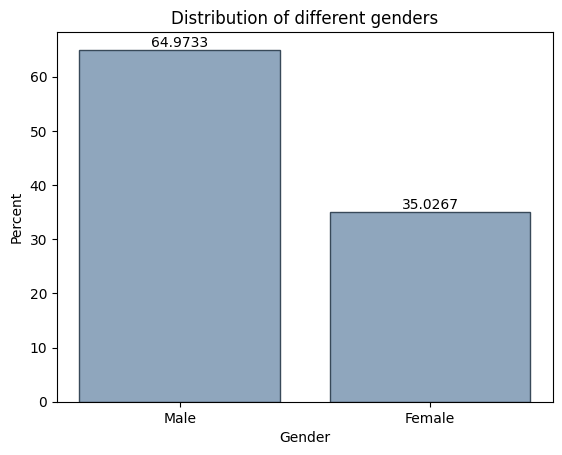

In [139]:
ax = sns.histplot(df_all['Gender'], color=colors[0], shrink=0.8, edgecolor=colors[-1], stat='percent')
ax.set_title('Distribution of different genders')
ax.bar_label(ax.containers[0])
plt.show()

/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_11506/2641702592.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


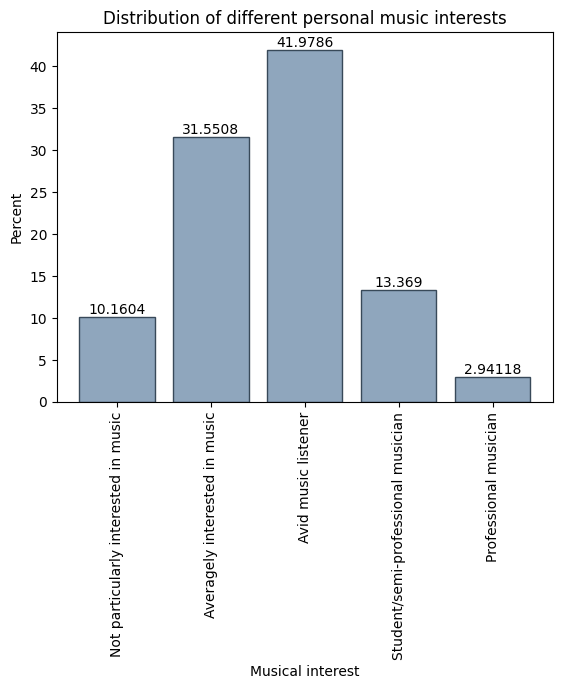

In [161]:
order = ['Not particularly interested in music', 'Averagely interested in music', 'Avid music listener', 'Student/semi-professional musician', 'Professional musician']
to_plot = pd.Categorical(df_all['Personal description'], categories=order, ordered=True)

ax = sns.histplot(to_plot, color=colors[0], shrink=0.8, edgecolor=colors[-1], stat='percent')
ax.set_title('Distribution of different personal music interests')
ax.set_xlabel('Musical interest')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.bar_label(ax.containers[0])
plt.show()